In [1]:
import numpy as np
import pandas as pd

files = [f"C:/Users/fred/Desktop/hearts-signal/entrainment/data/250527/T8_sesion_ADR+IV_HEART/ECG_c{i}.txt" for i in [1,2,3,4]]

def read_numpy_array_from_file(file_path):
    try:
        data = pd.read_csv(file_path, sep="\t", names=['peak', 'ECG', 'smoothed', 'timestamp'], 
                           comment='#', dtype={'peak': 'Int64', 'ECG': 'Int64', 'smoothed': float, 'timestamp': 'Int64'})
        return data
    except Exception as e:
        print(f"Error reading the numpy array from the file: {e}")
        return None

reading_dfs = []
for i in [1,2,3,4]:
    aux_df = read_numpy_array_from_file(files[i -1])
    if isinstance(aux_df, pd.DataFrame) and not aux_df.empty:
        reading_dfs.append(aux_df)

print(reading_dfs)


[       peak   ECG  smoothed  timestamp
0         0  5846  0.005061       <NA>
1         0  5920  0.013343       <NA>
2         0  5926  0.001079       <NA>
3         0  5964  0.006811       <NA>
4         0  5784 -0.032160       <NA>
...     ...   ...       ...        ...
59995     0  5012 -0.022426       <NA>
59996     0  4972 -0.007203       <NA>
59997     0  4982  0.001819       <NA>
59998     0  4990  0.001458       <NA>
59999     0  5028  0.006900       <NA>

[60000 rows x 4 columns],        peak   ECG  smoothed  timestamp
0         0  5304  0.008349       <NA>
1         0  5344  0.007590       <NA>
2         0  5394  0.009480       <NA>
3         0  5440  0.008712       <NA>
4         0  5460  0.003781       <NA>
...     ...   ...       ...        ...
60095     0  5256 -0.006944       <NA>
60096     0  5280  0.004619       <NA>
60097     0  5276 -0.000768       <NA>
60098     0  5258 -0.003450       <NA>
60099     0  5234 -0.004592       <NA>

[60100 rows x 4 columns]]


In [2]:
len(reading_dfs)

2

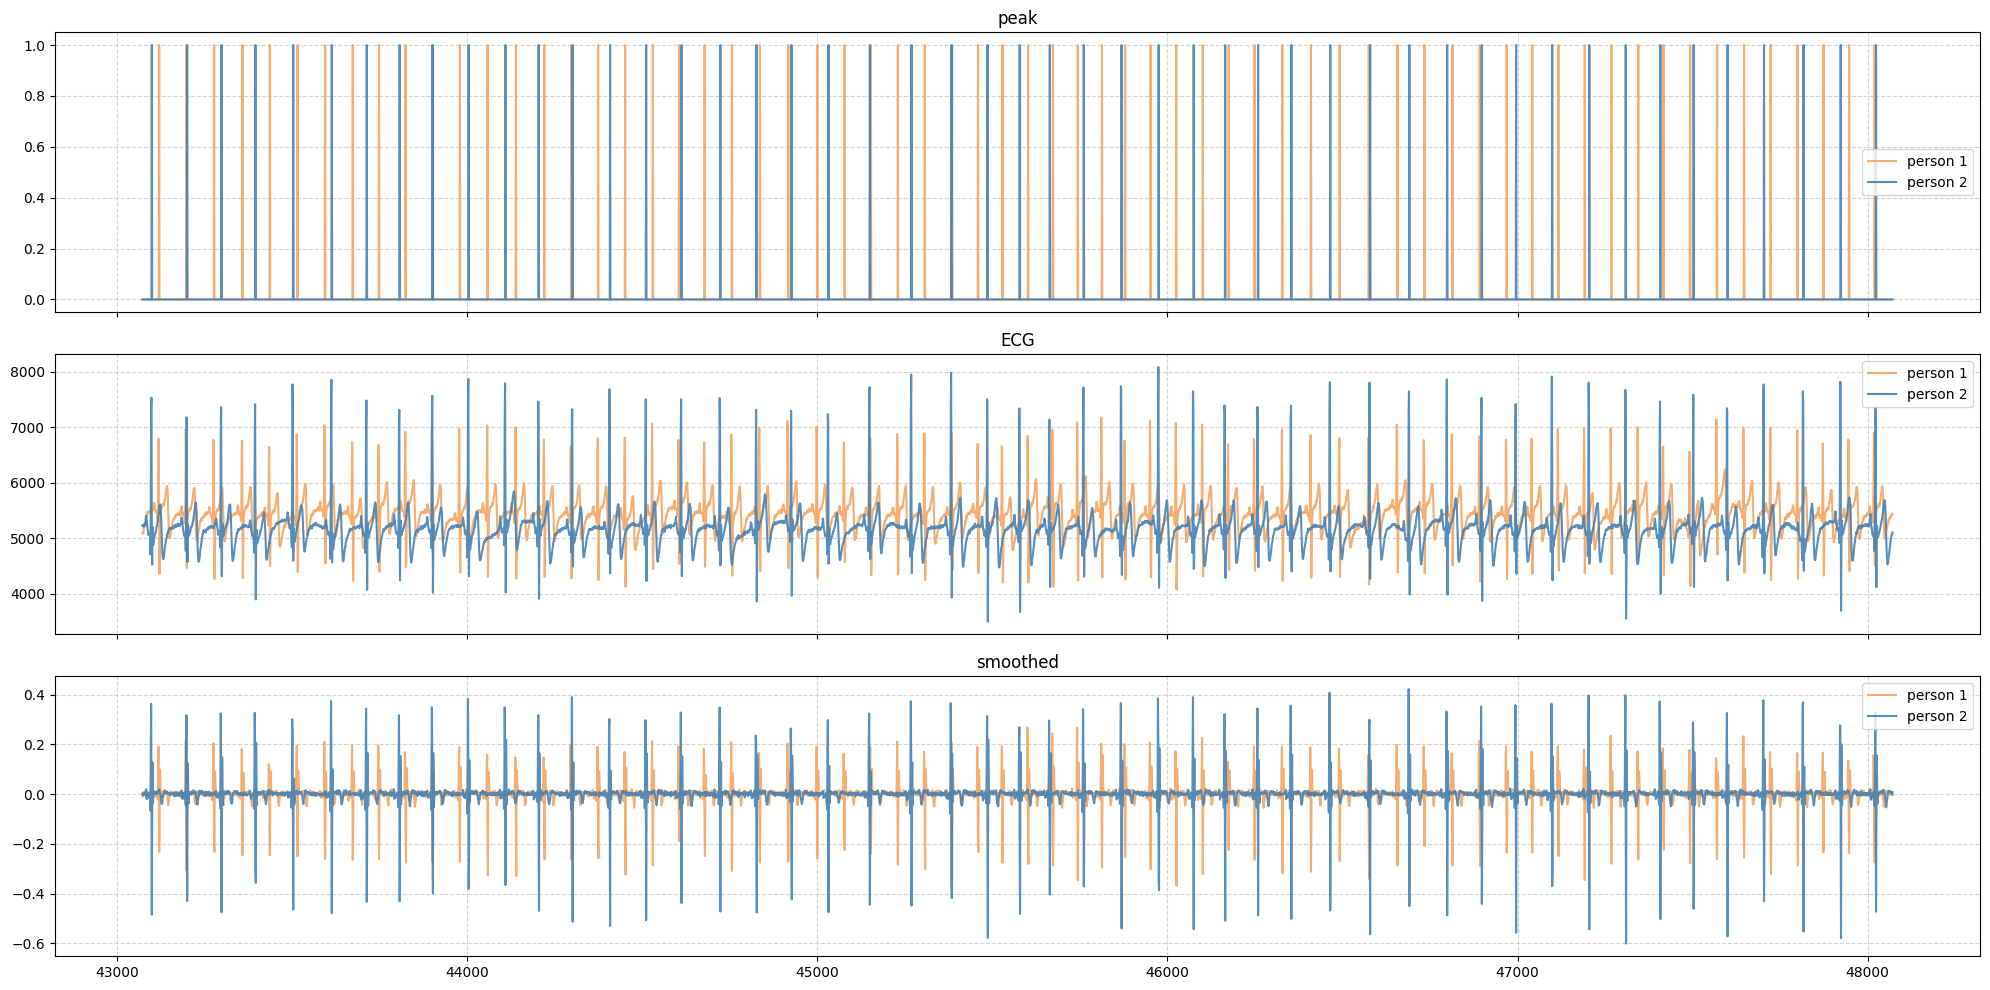

In [3]:
import matplotlib.pyplot as plt
import random

def plot_reading_data_overlap(dfs, window):
    # Ensure window size is valid
    for df in dfs:
        if window <= 0 or window > len(df):
            print("Window size must be greater than 0 and less than or equal to the length of the dataframe.")
            return

    # Create subplots
    fig, axs = plt.subplots(3, sharex=True, figsize=(20, 10))

    # Define colors for each patient
    colors = ['goldenrod', 'sandybrown', 'steelblue','olivedrab']

    start_index = random.randint(0, len(df) - window)
    
    for i, df in enumerate(dfs, start=1):
        # Select a random start index for the window
        

        # Select the window of data
        df_window = df.iloc[start_index : start_index + window]

        # Plot each column
        axs[0].plot(df_window['peak'], label=f'person {i}', color=colors[i], alpha=0.9)
        axs[1].plot(df_window['ECG'], label=f'person {i}', color=colors[i], alpha=0.9)
        axs[2].plot(df_window['smoothed'], label=f'person {i}', color=colors[i], alpha=0.9)

    # Set titles
    axs[0].set_title('peak')
    axs[1].set_title('ECG')
    axs[2].set_title('smoothed')

    # Add legend to each subplot
    for ax in axs:
        ax.legend()
        ax.grid(True, which='both', color='lightgray', linestyle='--')

    # Display the plot
    plt.tight_layout()
    plt.show()
# Test the function with the first reading and a window of 10
plot_reading_data_overlap(reading_dfs, 5000)

In [4]:
# from sync_analyzer_2CH import read_csv_data, plot_data, estimate_time_differences

# # //*-*-
# # //*-*-
# #dat0 = read_csv_data('D:/SK/PY/entrainment/T3/T3_4CH.csv')

# #plot_data(dat0, 0, 3000, 0)
# dts = estimate_time_differences(dat0, 100, 100, 0)
# plot_data(dat0, dts,  0, 30000, 0)



In [5]:
import pandas as pd

def align_dataframes_optimized(reading_dfs, sample_rate=100):
    df1 = reading_dfs[0]
    df2 = reading_dfs[1]

    # Interpolate missing values in the timestamp columns
    df1['timestamp'] = df1['timestamp'].interpolate()
    df2['timestamp'] = df2['timestamp'].interpolate()
    # Calculate the initial mean difference between the timestamp values
    initial_mean_diff = df2['timestamp'].mean() - df1['timestamp'].mean()

    # Convert the initial mean difference in timestamps to the number of rows
    initial_rows_diff = int(round(initial_mean_diff * sample_rate)) 

    print(f"Initial Mean diff: {initial_mean_diff}s")
    print(f"Initial shift: {initial_rows_diff} rows")

    # Initialize the best shift and best mean difference
    best_shift = initial_rows_diff
    best_mean_diff = initial_mean_diff

    # Try shifts in the range from -100 to 100
    for shift in range(-100, 101):
        # Shift the second dataframe by the current number of rows
        df2_shifted = df2.shift(periods=shift)

        # Concatenate the datasets side by side with _1 and _2 suffixes
        aligned_df = pd.concat([df1.add_suffix('_1').reset_index(drop=True), df2_shifted.add_suffix('_2').reset_index(drop=True)], axis=1)

        # Calculate the mean difference with the current shift
        mean_diff = aligned_df['timestamp_1'].mean() - aligned_df['timestamp_2'].mean()

        # If the absolute mean difference is smaller than the best mean difference so far, update the best shift and best mean difference
        if abs(mean_diff) < abs(best_mean_diff):
            best_shift = shift
            best_mean_diff = mean_diff

    # Shift the second dataframe by the best number of rows
    df2_shifted = df2.shift(periods=best_shift)

    # Concatenate the datasets side by side with _1 and _2 suffixes
    aligned_df = pd.concat([df1.add_suffix('_1').reset_index(drop=True), df2_shifted.add_suffix('_2').reset_index(drop=True)], axis=1)

    # Trim to the minimum length of the original datasets
    aligned_df = aligned_df.dropna(subset=['peak_1', 'peak_2'])

    min_length = min(len(df1), len(df2))
    aligned_df = aligned_df.iloc[:min_length]

    print(f"Best shift: {best_shift} rows")
    print(f"Final timestamp Mean diff: {best_mean_diff}s")

    # Return the aligned dataframe
    return aligned_df


aligned_df = align_dataframes_optimized(reading_dfs, sample_rate=100)


Initial Mean diff: -0.07819700241088867s
Initial shift: -8 rows
Best shift: -93 rows
Final timestamp Mean diff: -0.0017576217651367188s


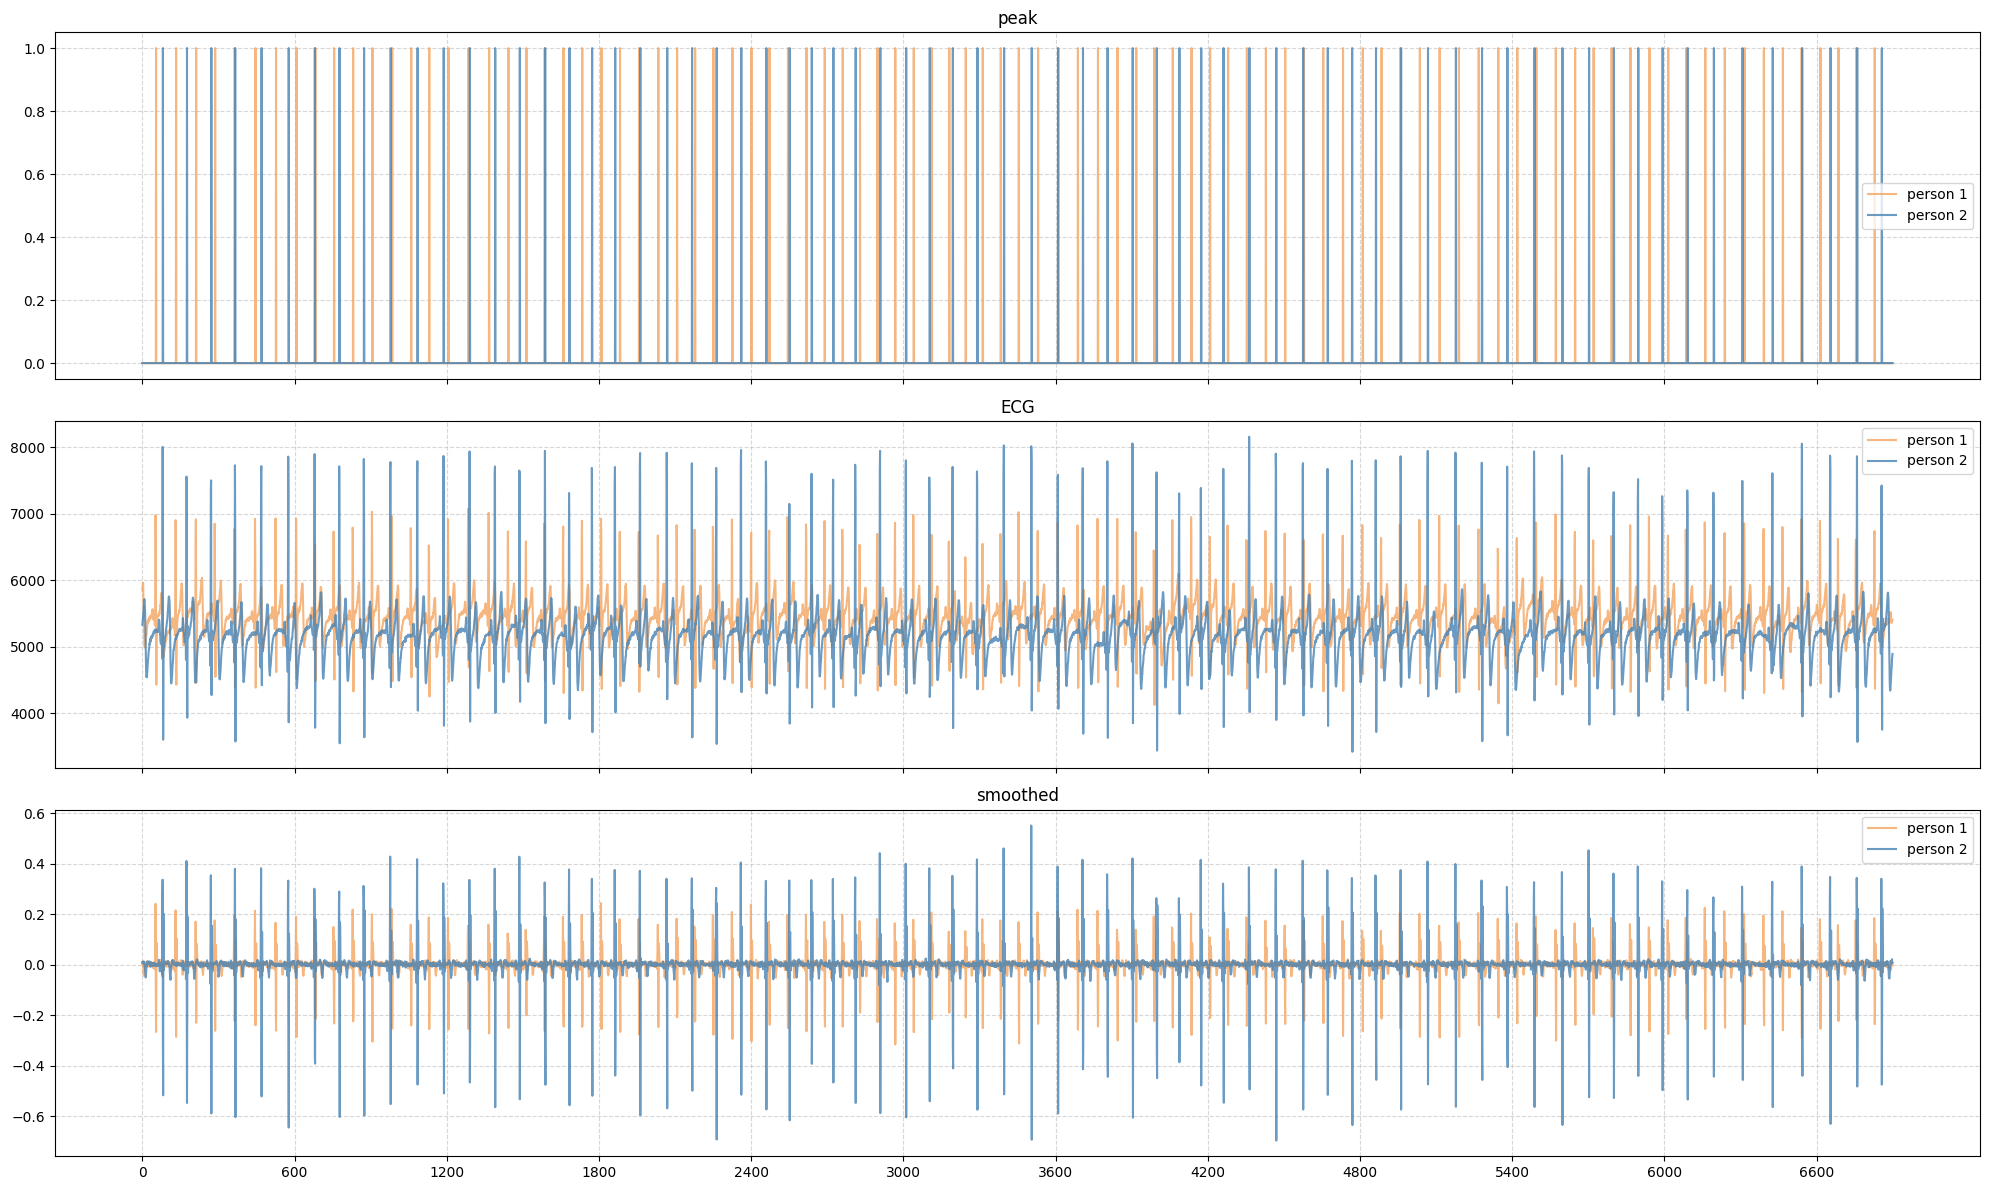

In [6]:
import matplotlib.pyplot as plt

def plot_reading_data_overlap(df, start_index, stop_index):
    # Ensure start and stop indexes are valid
    if start_index < 0 or stop_index > len(df) or start_index >= stop_index:
        print("Start and stop indexes must be within the range of the dataframe and start_index should be less than stop_index.")
        return

    # Create subplots
    fig, axs = plt.subplots(3, sharex=True, figsize=(20, 12))

    # Define colors for each dataset
    colors = ['sandybrown', 'steelblue']

    # Select the window of data
    df_window = df.iloc[start_index : stop_index]

    # Plot data for the first dataset
    axs[0].plot(df_window['peak_1'], label='person 1', color=colors[0], alpha=0.8)
    axs[1].plot(df_window['ECG_1'], label='person 1', color=colors[0], alpha=0.8)
    axs[2].plot(df_window['smoothed_1'], label='person 1', color=colors[0], alpha=0.8)

    # Plot data for the second person
    axs[0].plot(df_window['peak_2'], label='person 2', color=colors[1], alpha=0.8)
    axs[1].plot(df_window['ECG_2'], label='person 2', color=colors[1], alpha=0.8)
    axs[2].plot(df_window['smoothed_2'], label='person 2', color=colors[1], alpha=0.8)

    # Set titles
    axs[0].set_title('peak')
    axs[1].set_title('ECG')
    axs[2].set_title('smoothed')

    # Add legend to each subplot
    for ax in axs:
        ax.legend()
        ax.grid(axis='both', linestyle='--',  alpha=0.5)

        # Set x axis labels as multiples of 600
        x_ticks = range(start_index, stop_index + 1, 600)
        ax.set_xticks(x_ticks)


    # Display the plot
    plt.tight_layout()
    plt.show()

# Assuming aligned_df is the combined dataframe
plot_reading_data_overlap(aligned_df, 0, 6900)


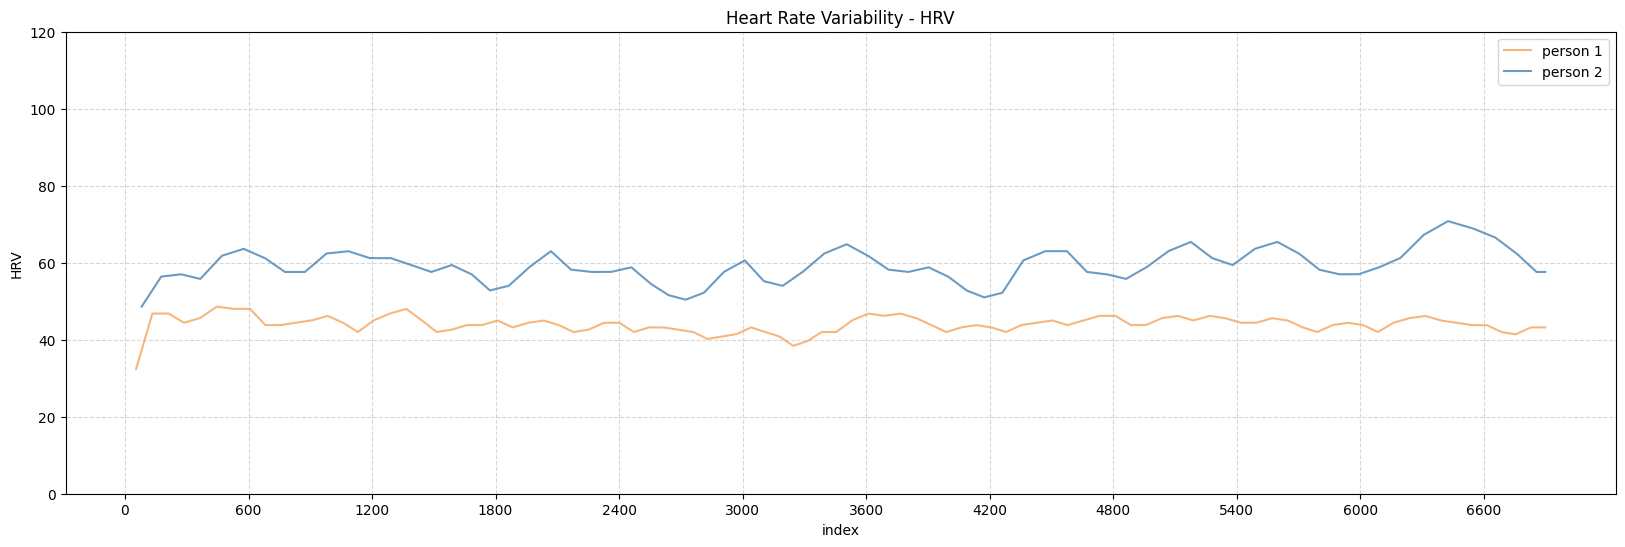

In [7]:
def calculate_hrv(aligned_df, num_persons=2):
    # Iterate over all persons
    for i in range(num_persons):
        # Select the 'beat' column for the current person
        beat_col = f'peak_{i+1}'

        if 'hrv' in aligned_df.columns:
            aligned_df.drop('hrv', axis=1, inplace=True)
        # Initialize a counter for 0 value readings
        zero_counter = 0
        # Initialize an empty list to store the counts of 0 value readings before each beat
        zero_counts = []

        # Iterate over the 'beat' column
        for beat in aligned_df[beat_col]:
            if beat == 0:
                # Increment the counter if the beat is 0
                zero_counter += 1
                zero_counts.append(None)
            elif beat == 1:
                # Convert the count of zeros to beats per minute (bpm)
                # We have 100 readings per second, so we multiply by 60 to get bpm
                bpm = (zero_counter * 60) / 100
                # Append the bpm to the list and reset the counter
                zero_counts.append(bpm)
                zero_counter = 0

        # Add hrv as a new column to the dataframe
        aligned_df[f'hrv_{i+1}'] = zero_counts
# Use the function to calculate the heart rate variability
calculate_hrv(aligned_df)

def plot_hrv_data(aligned_df, start, stop, num_persons=2):
    # Create a figure and axes
    fig, axs = plt.subplots(figsize=(20, 6))

    colors = [ 'sandybrown', 'steelblue','goldenrod','olivedrab']

    # Iterate over all persons
    for i in range(num_persons):
        # Get the HRV values and corresponding indices
        hrv_values = aligned_df[f'hrv_{i+1}'][start:stop].interpolate()
        hrv_indices = hrv_values.index

        # Plot the HRV data as a continuous line
        axs.plot(hrv_indices, hrv_values, color=colors[i], alpha=0.8, label=f'person {i+1}')

    axs.set_title('Heart Rate Variability - HRV')
    axs.set_xlabel('index')
    axs.set_ylabel('HRV')
    axs.set_ylim(0, 120)  # Set the y-axis range from 0 to 120
    axs.legend()
    axs.grid(axis='both', linestyle='--',  alpha=0.5)  # Add gridlines on both axes

    # Set x axis labels as multiples of 600
    x_ticks = range(start, stop + 1, 600)
    axs.set_xticks(x_ticks)

    # Show the plot in a new window
    plt.show()
# Use the function to plot HRV data
plot_hrv_data(aligned_df, 0, 6900)


In [17]:
aligned_df

,peak_1,ECG_1,smoothed_1,timestamp_1,peak_2,ECG_2,smoothed_2,timestamp_2,hrv_1,hrv_2
0,0,5846,0.005061,<NA>,0,5330,0.011027,1716862575.164948,NaN,NaN
1,0,5920,0.013343,<NA>,0,5382,0.009887,1716862575.175258,NaN,NaN
2,0,5926,0.001079,<NA>,0,5412,0.005700,1716862575.185567,NaN,NaN
3,0,5964,0.006811,<NA>,0,5464,0.009867,1716862575.195876,NaN,NaN
4,0,5784,-0.032160,<NA>,0,5500,0.006819,1716862575.206186,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
59995,0,5012,-0.022426,1716863174.0,0,5294,0.008344,1716863173.0,NaN,NaN
59996,0,4972,-0.007203,1716863174.0,0,5286,-0.001581,1716863173.0,NaN,NaN
59997,0,4982,0.001819,1716863174.0,0,5294,0.001573,1716863173.0,NaN,NaN
59998,0,4990,0.001458,1716863174.0,0,5302,0.001566,1716863173.0,NaN,NaN


In [62]:
import pandas as pd
import numpy as np

import numpy as np

def estimate_time_differences(data, sample_frequency, window_size = 100, base_signal_index=0):
    """
    For each window of 100 samples, estimate the time difference between the pulse in the signal from the first group and the pulses in the samples of the other groups in the windows.
    Add a new column for each group with the value of the corresponding time difference for all the 100 positions of the time window.
    Save the resulting differences in 'dts.csv'.

    Args:
    data (DataFrame): The data to process, expected to have 12 columns.
    sample_frequency (int): The number of samples per second.
    window_size (int): The number of samples per window.
    base_signal_index (int): The index of the signal used as reference (0, 1, 2, or 3).
    """
    # Calculate the time interval between samples in seconds
    time_interval_seconds = 1 / sample_frequency
    # Number of windows
    num_windows = data.shape[0] // window_size

    # Prepare DataFrame to store time differences
    time_diffs = pd.DataFrame(index=np.arange(num_windows * window_size))
    time_diffs_features = pd.DataFrame(index=np.arange(num_windows))
    deltas = [[] for _ in range(2)]
    deltas_features = [[] for _ in range(2)]

    #select the base signal
    base_signal = data.iloc[:, base_signal_index]
    signals = [[] for _ in range(2)]
    for i in range(2):
        signals[i] = data.iloc[:, i * 4]

    # Process each window, group by group
    for w in range(num_windows):
        base_window = base_signal[w*window_size:(w+1)*window_size]
        base_pulses = np.where(base_window > 0)[0]
        for i in range(2):
            window = signals[i][w*window_size:(w+1)*window_size]
            # Find index of pulses in the window
            pulses = np.where(window > 0)[0]
            # Calculate time differences for pulses in the window
            if len(pulses) > 0 and len(base_pulses) > 0:
                pulse_diff_time = (base_pulses[0] - pulses[0]) * time_interval_seconds
            else:
                pulse_diff_time = -1  # No pulse in this window
            # Fill the window with the time difference
            deltas[i].extend([pulse_diff_time]*window_size)
            deltas_features[i].append(pulse_diff_time)
    for i in range(2):
        time_diffs[f'Group{i+1}_Delta'] = deltas[i]
        time_diffs_features[f'Group{i+1}_Delta'] = deltas_features[i]
        
    # Add HRV data to the time differences dataframe
    for i in range(2):
        hrv_data = data[f'hrv_{i+1}'].fillna(np.nan)
        hrv_data_windowed = [hrv_data[i:i+window_size].mean() for i in range(0, len(hrv_data), window_size)]
        hrv_data_windowed = pd.Series(hrv_data_windowed).interpolate().tolist()  # Fill NaN values with the mean of the column
        time_diffs[f'hrv_{i+1}'] = hrv_data_windowed * window_size
        time_diffs_features[f'hrv_{i+1}'] = hrv_data_windowed

    # Save the DataFrame to CSV
    time_diffs.to_csv('dts.csv', index=False)
    time_diffs_features.to_csv('dts_features.csv', index=False)
    return time_diffs# Example usage
# Assuming aligned_df is the combined dataframe
sample_frequency = 100  # Adjust as necessary
window_size = 120
dts = estimate_time_differences(aligned_df, sample_frequency, window_size)



In [63]:
dts

,Group1_Delta,Group2_Delta,hrv_1,hrv_2
0,0.0,-0.27,32.4,48.6
1,0.0,-0.27,46.8,56.4
2,0.0,-0.27,44.4,57.0
3,0.0,-0.27,47.1,58.8
4,0.0,-0.27,48.0,63.6
...,...,...,...,...
59995,0.0,-0.42,44.4,48.6
59996,0.0,-0.42,46.8,69.6
59997,0.0,-0.42,46.5,71.4
59998,0.0,-0.42,45.6,67.2


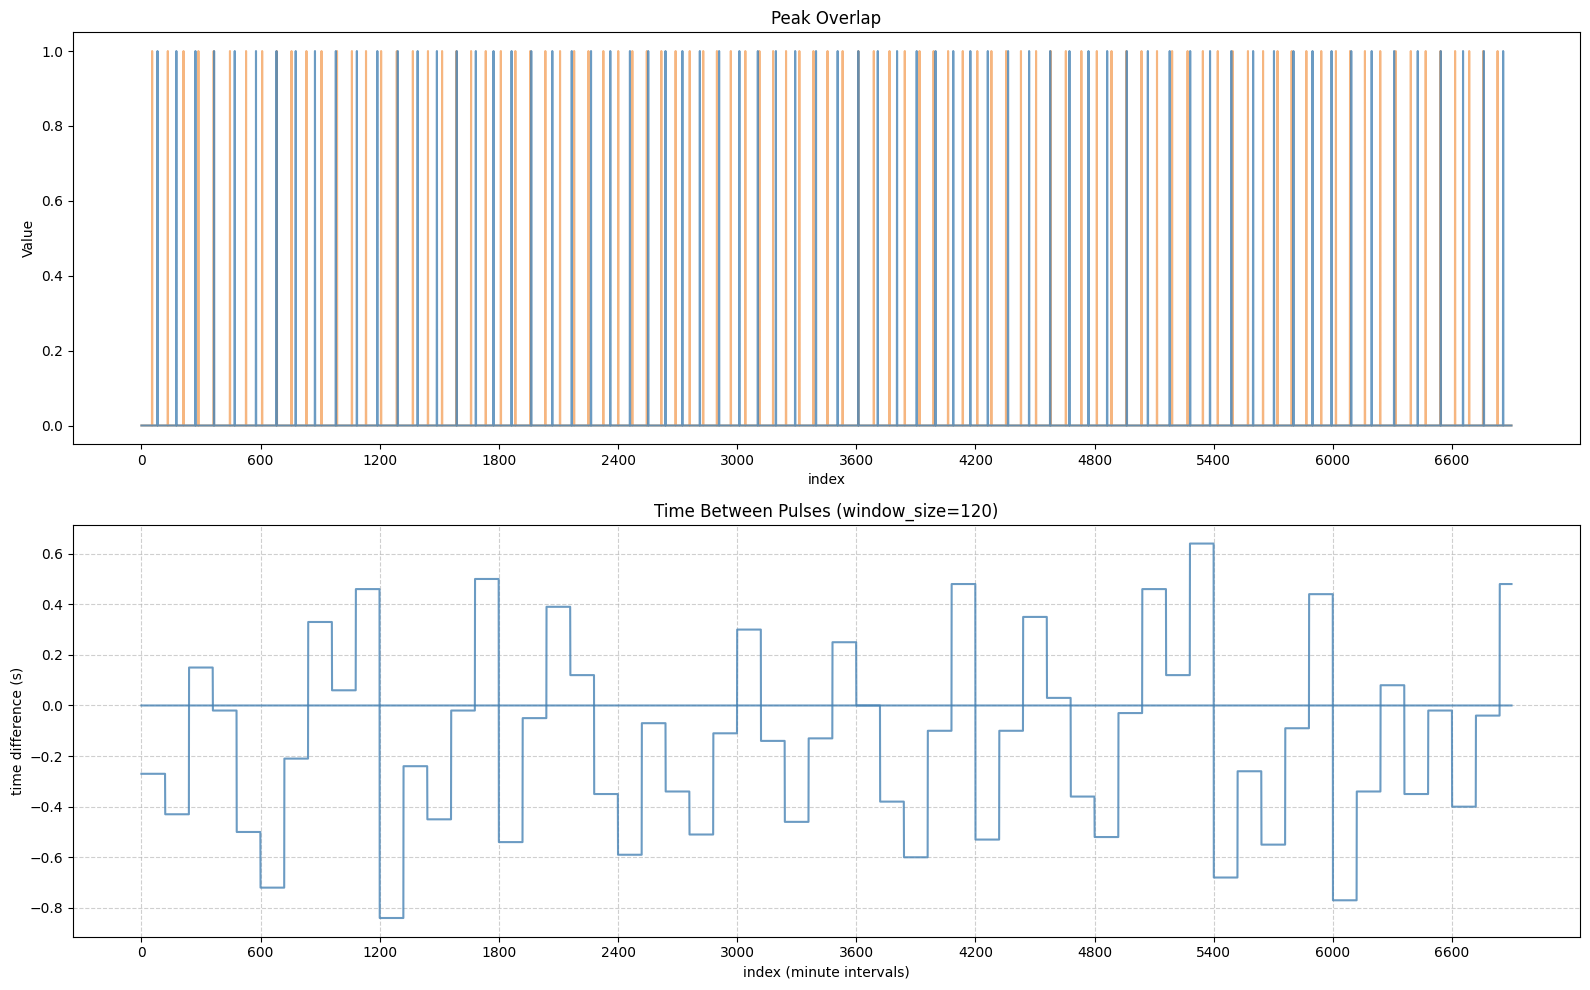

In [64]:
import matplotlib.pyplot as plt

def plot_time_between_pulses(data, dts, start_index, end_index, value_index, ilist=[0,1], plot_channels=False):
    """
    Plots selected data from a specified range and column index for each group, and plots the time differences.

    Args:
    data (DataFrame): The data to plot, expected to have 12 columns.
    dts (DataFrame): The data object containing time differences to plot.
    start_index (int): The starting index of the range of data points to plot.
    end_index (int): The ending index of the range of data points to plot.
    value_index (int): The index of the value to plot in each group (0, 1, or 2).
    ilist(list): list of indexes, for operating over a data subset
    plot_channels (bool): Whether to plot the channels subplot
    """
    lil = len(ilist)
    #
    if value_index < 0 or value_index > 2:
        raise ValueError("value_index must be 0, 1, or 2")
    colors = [ 'sandybrown', 'steelblue']  # Colors for the plots
    x_ticks = range(start_index, end_index + 1, 600)

    if plot_channels:
        fig, axs = plt.subplots(2, 1, figsize=(16, 10))  # Two subplots, one for overlayed channels and one for dts plot
        for i in range(lil):
            i_i = ilist[i]
            col_index = i_i * 4 + value_index
            axs[0].plot(data.iloc[start_index:end_index, col_index], color=colors[i % len(colors)], alpha=0.8)
        axs[0].set_title('Peak Overlap')
        axs[0].set_xlabel('index')
        axs[0].set_ylabel('Value')
        axs[0].set_xticks(x_ticks)

        # Plotting the time differences data in its own subplot
        axs[1].plot(dts.iloc[start_index:end_index, ilist], color = colors[1],  alpha=0.8)  # 'k' for black color
        axs[1].set_title(f'Time Between Pulses (window_size={window_size})')
        axs[1].set_xlabel('index (minute intervals)')
        axs[1].set_ylabel('time difference (s)')
        axs[1].set_xticks(x_ticks)
        axs[1].grid(axis='both', linestyle='--',  alpha=0.6)  # Add gridlines on both axes

    else:
        fig, axs = plt.subplots(figsize=(16, 5))  # One subplot for dts plot
        axs.plot(dts.iloc[start_index:end_index, ilist], color = colors[1],  alpha=0.8)  # 'k' for black color
        axs.set_title(f'Time Between Pulses (window_size={window_size})')
        axs.set_xlabel('index (minute intervals)')
        axs.set_ylabel('time difference (s)')
        # Set x axis labels as multiples of 600
        axs.set_xticks(x_ticks)
        axs.grid(axis='both', linestyle='--',  alpha=0.6)  # Add gridlines on both axes



    plt.tight_layout()
    plt.show()
# Example usage
# Assuming aligned_df is the combined dataframe and dts is the time differences dataframe
plot_time_between_pulses(aligned_df, dts, 0, 6900, 0, plot_channels=True)


## Todo junto

In [65]:
def combined_plot(data, dts, start_index, stop_index, value_index, ilist=[0,1]):
    plot_reading_data_overlap(aligned_df, start_index, stop_index)
    plot_hrv_data(data, start_index, stop_index)
    plot_time_between_pulses(data, dts, start_index, stop_index, value_index, ilist)


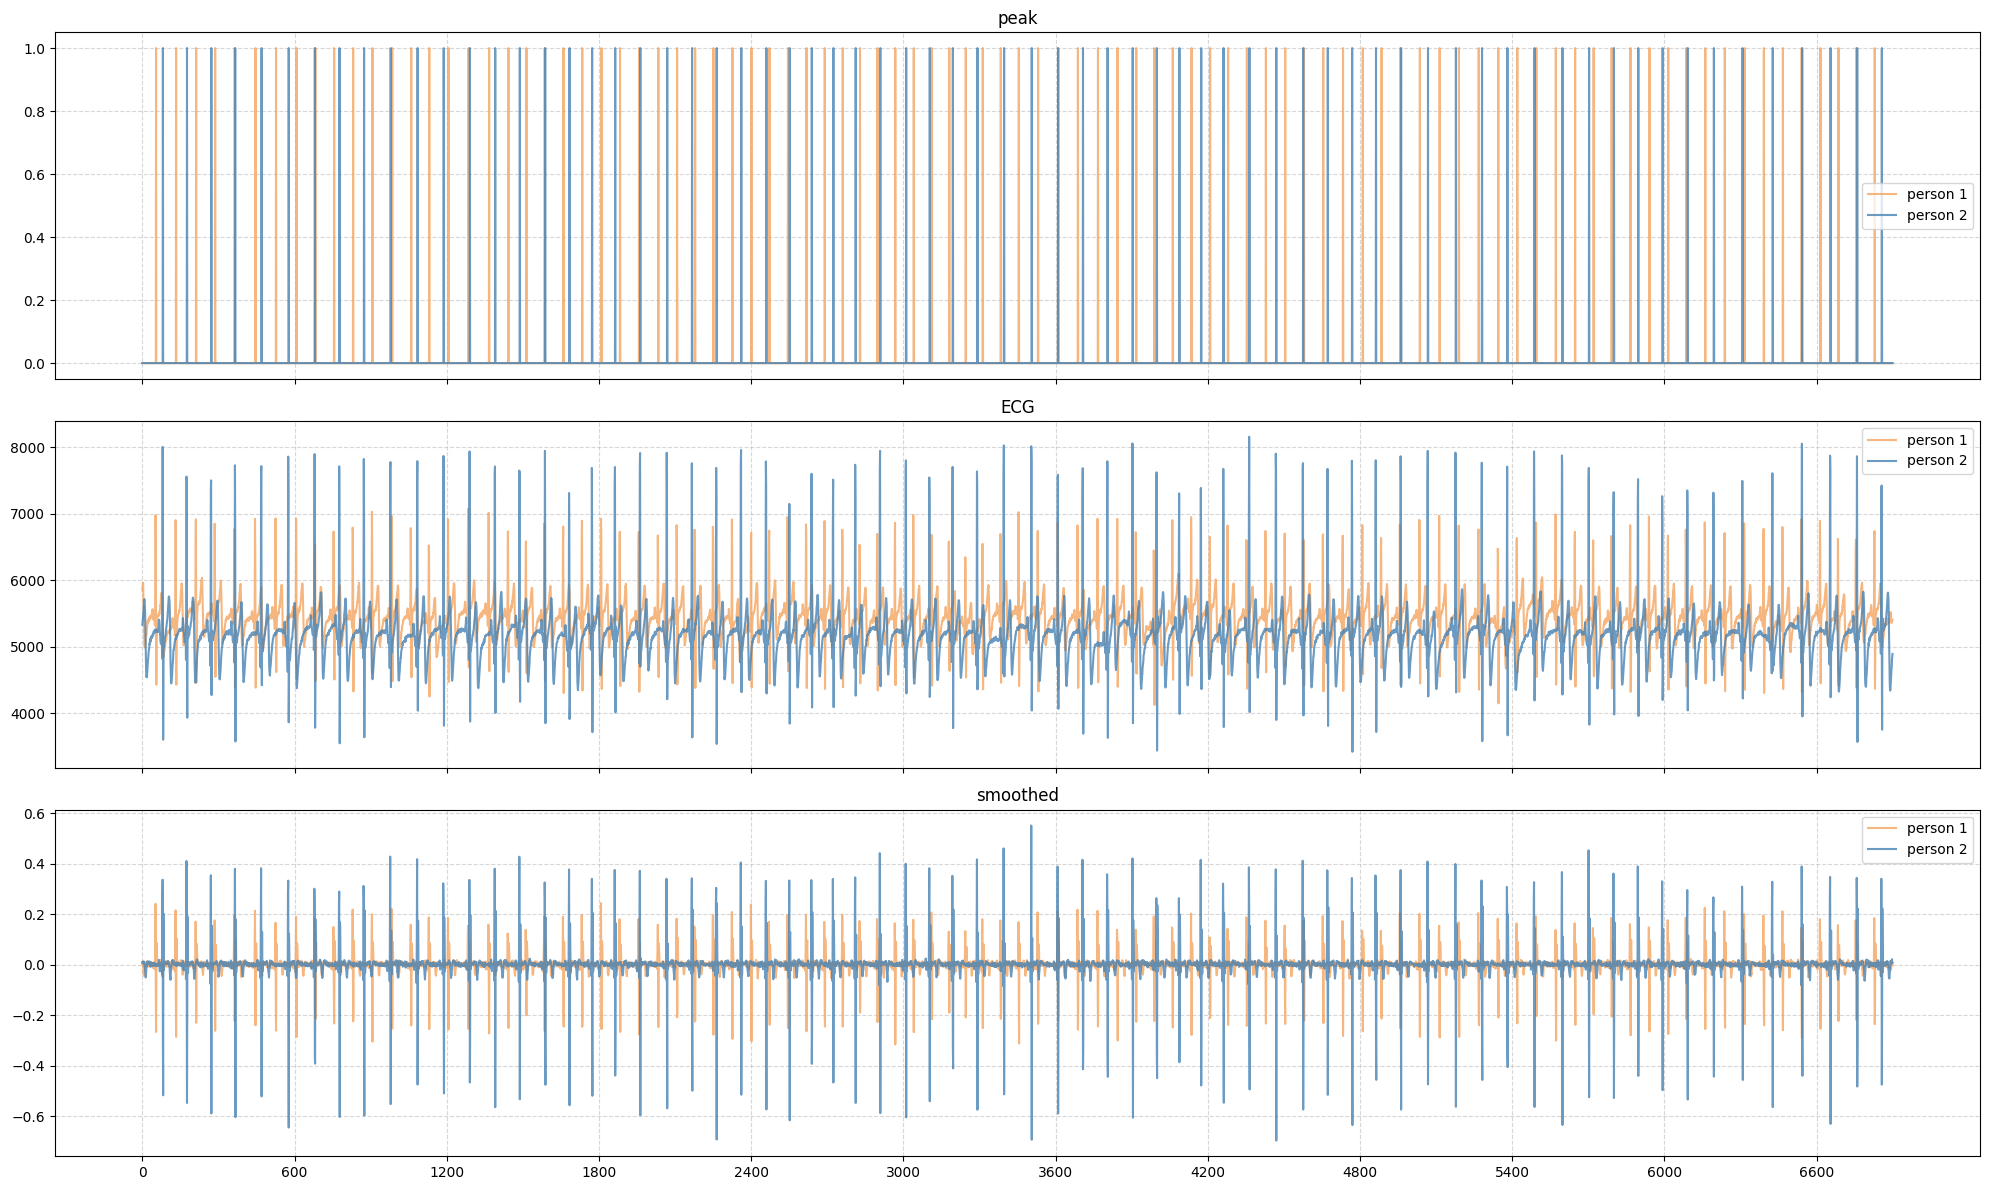

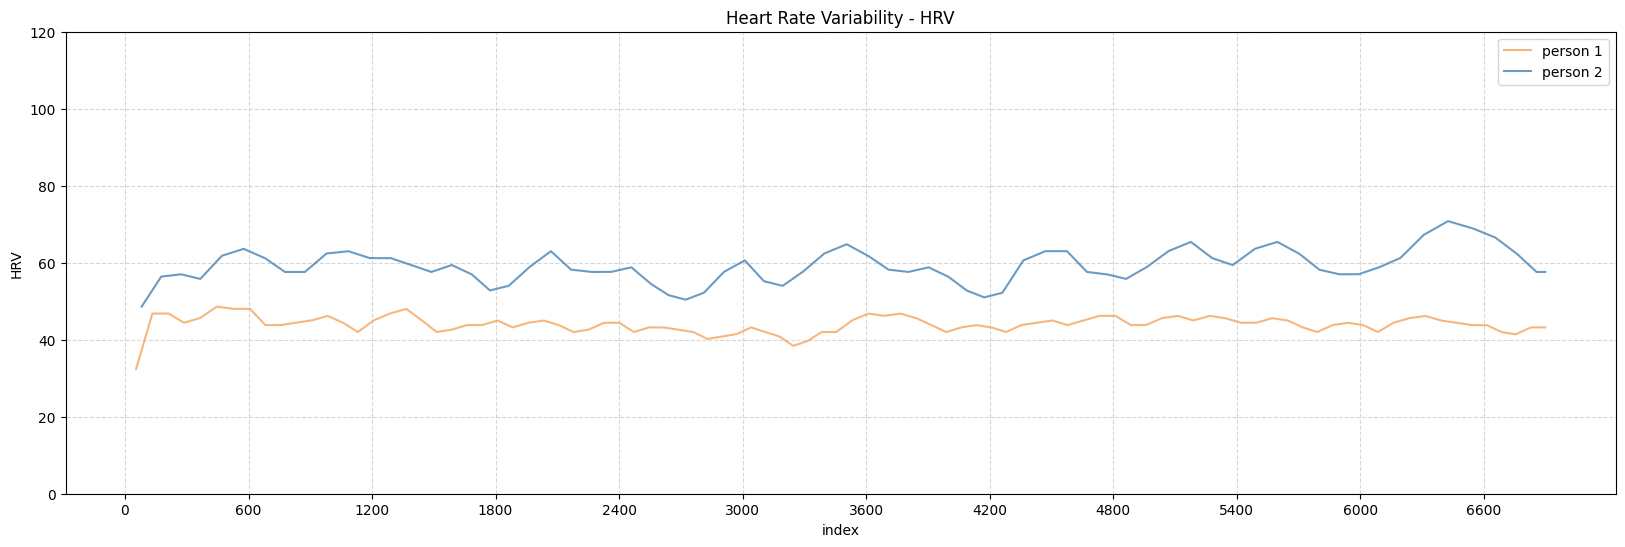

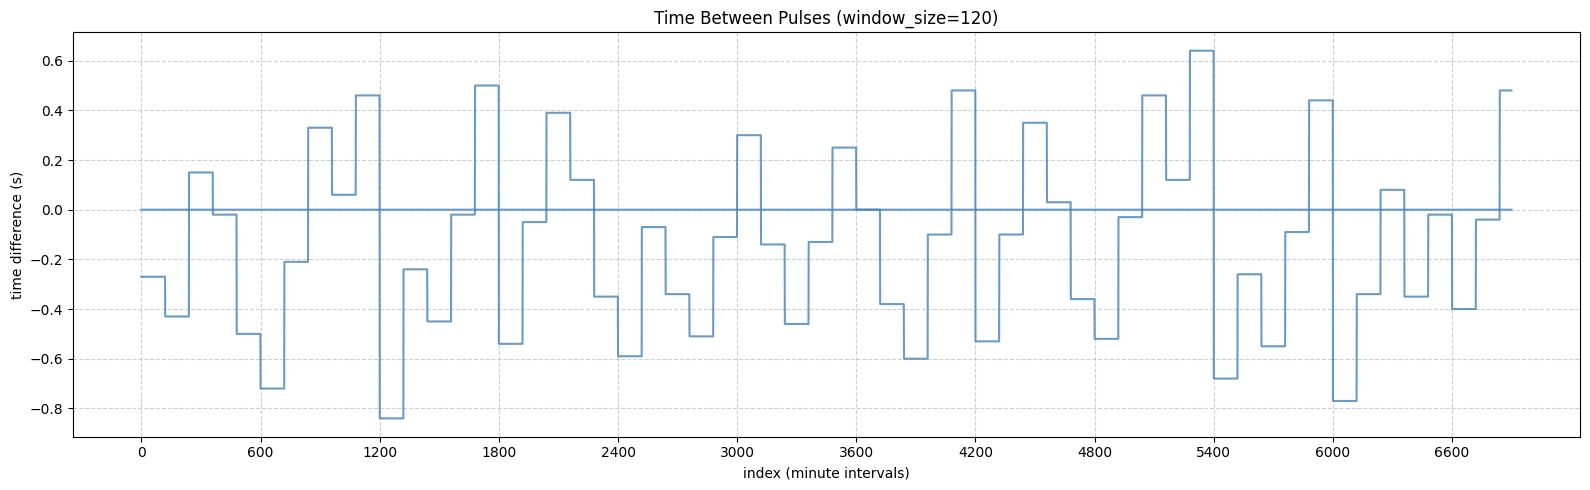

In [66]:
# Assuming data, dts, and ecg_data are your dataframes
# start_index, end_index, value_index are the indices for your data
# start and stop are the start and stop indices for your HRV data

start_index = 0
end_index = 6900
value_index = 0

combined_plot(data=aligned_df, dts=dts, start_index=start_index, stop_index=end_index, value_index=0, ilist=[0,1] )

In [67]:
aligned_df

,peak_1,ECG_1,smoothed_1,timestamp_1,peak_2,ECG_2,smoothed_2,timestamp_2,hrv_1,hrv_2
0,0,5846,0.005061,<NA>,0,5330,0.011027,1716862575.164948,NaN,NaN
1,0,5920,0.013343,<NA>,0,5382,0.009887,1716862575.175258,NaN,NaN
2,0,5926,0.001079,<NA>,0,5412,0.005700,1716862575.185567,NaN,NaN
3,0,5964,0.006811,<NA>,0,5464,0.009867,1716862575.195876,NaN,NaN
4,0,5784,-0.032160,<NA>,0,5500,0.006819,1716862575.206186,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
59995,0,5012,-0.022426,1716863174.0,0,5294,0.008344,1716863173.0,NaN,NaN
59996,0,4972,-0.007203,1716863174.0,0,5286,-0.001581,1716863173.0,NaN,NaN
59997,0,4982,0.001819,1716863174.0,0,5294,0.001573,1716863173.0,NaN,NaN
59998,0,4990,0.001458,1716863174.0,0,5302,0.001566,1716863173.0,NaN,NaN


## Sin musica ni corazones - comienzo


In [27]:
files = [f"C:/Users/fred/Desktop/hearts-signal/entrainment/data/250527/T8_sesion_ADR+IV_noHEART/ECG_c{i}.txt" for i in [1,2,3,4]]

reading_dfs = [read_numpy_array_from_file(files[i -1]) for i in [1,2,3,4]]
reading_dfs = [e for e in reading_dfs if not e.empty]

print(reading_dfs)

[       peak   ECG  smoothed   timestamp
0         0  6924  0.215304        <NA>
1         0  6554 -0.067930        <NA>
2         1  5006 -0.281851  1716861811
3         0  4210 -0.145102        <NA>
4         0  4746  0.098320        <NA>
...     ...   ...       ...         ...
59995     0  5166 -0.032997        <NA>
59996     0  5052 -0.020536        <NA>
59997     0  4964 -0.016029        <NA>
59998     0  4970  0.001101        <NA>
59999     0  4996  0.004761        <NA>

[60000 rows x 4 columns],        peak   ECG  smoothed  timestamp
0         0  4612 -0.025080       <NA>
1         0  4556 -0.010751       <NA>
2         0  4544 -0.002310       <NA>
3         0  4500 -0.008495       <NA>
4         0  4670  0.032869       <NA>
...     ...   ...       ...        ...
60195     0  5126  0.010481       <NA>
60196     0  5126  0.000000       <NA>
60197     0  5152  0.005057       <NA>
60198     0  5156  0.000779       <NA>
60199     0  5158  0.000390       <NA>

[60200 rows x 4 columns

In [29]:
aligned_df = align_dataframes_optimized(reading_dfs, sample_rate=100)
# aligned_df = reading_dfs

Initial Mean diff: 0.11630487442016602s
Initial shift: 12 rows
Best shift: 23 rows
Final timestamp Mean diff: -0.0013184547424316406s


In [30]:
sample_frequency = 100  # Adjust as necessary
window_size = 100
dts = estimate_time_differences(aligned_df, sample_frequency, window_size)


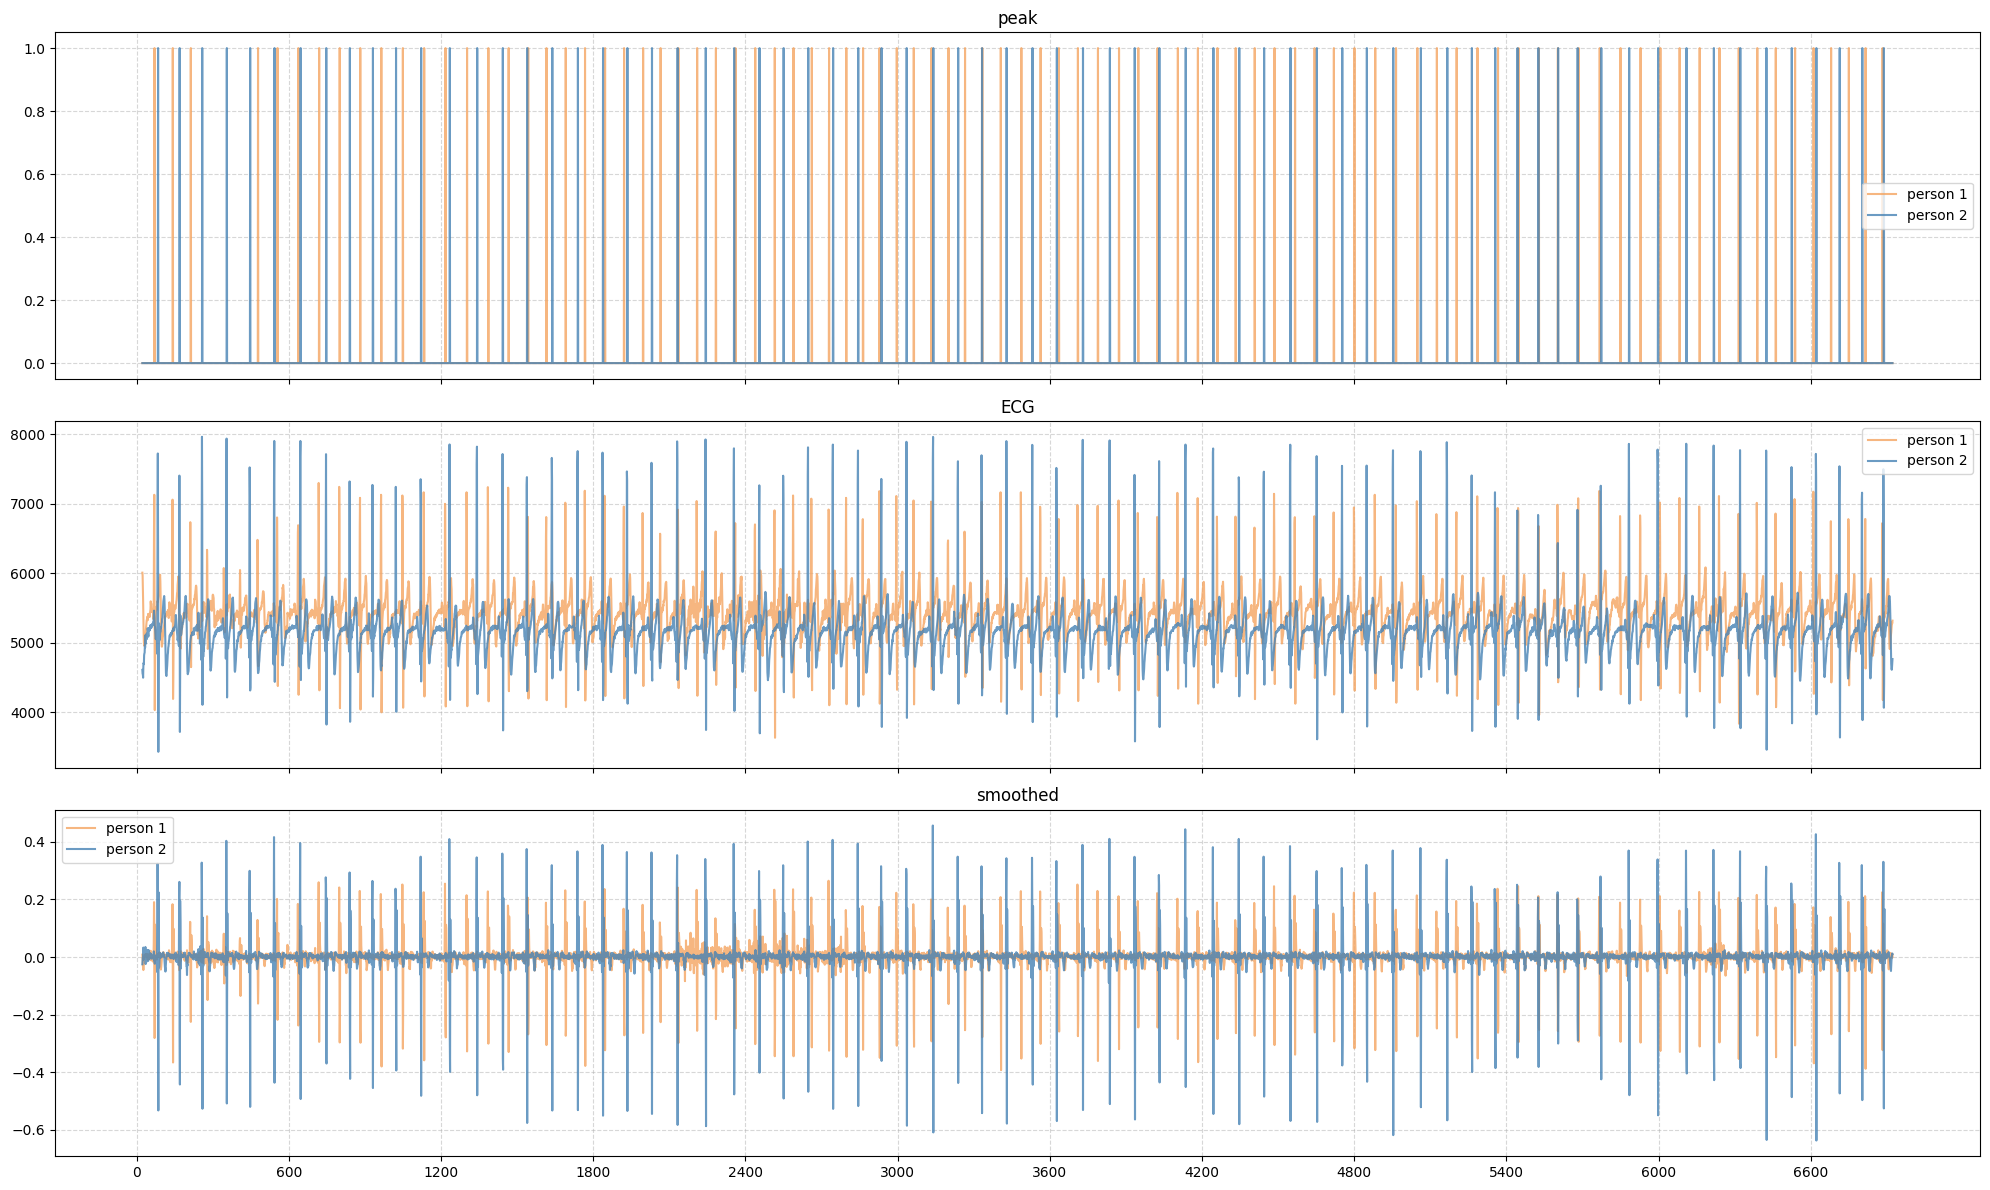

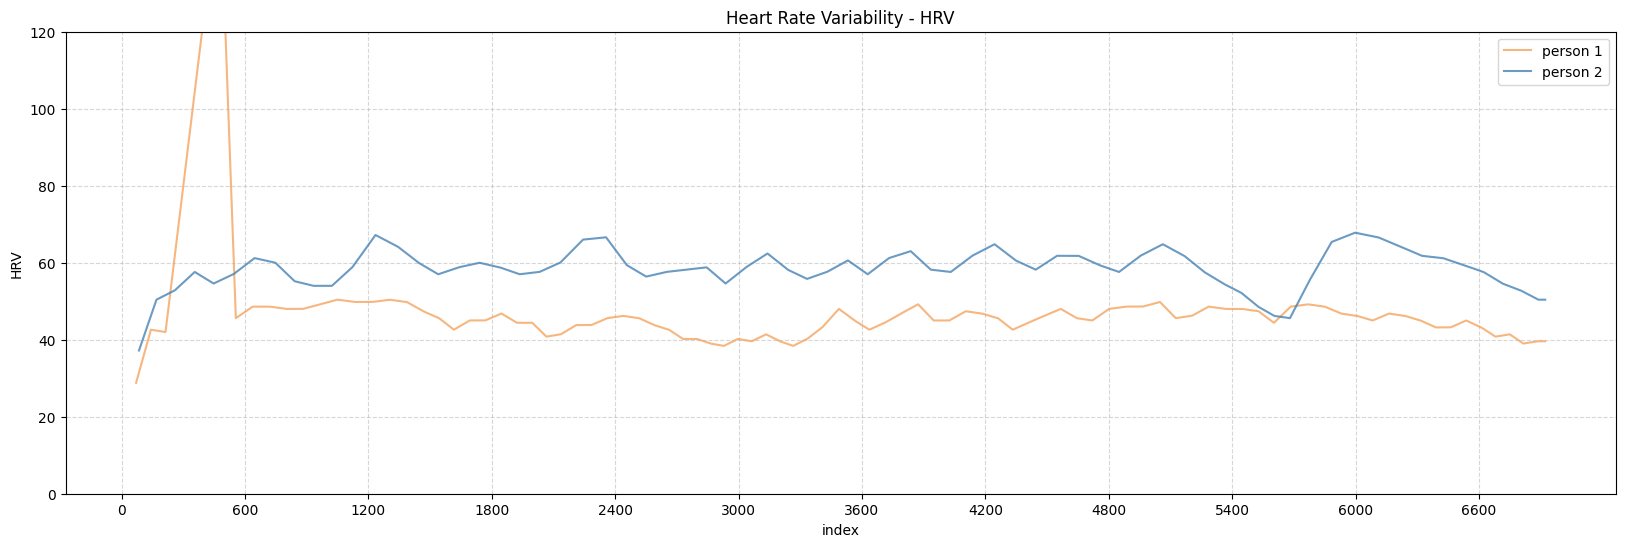

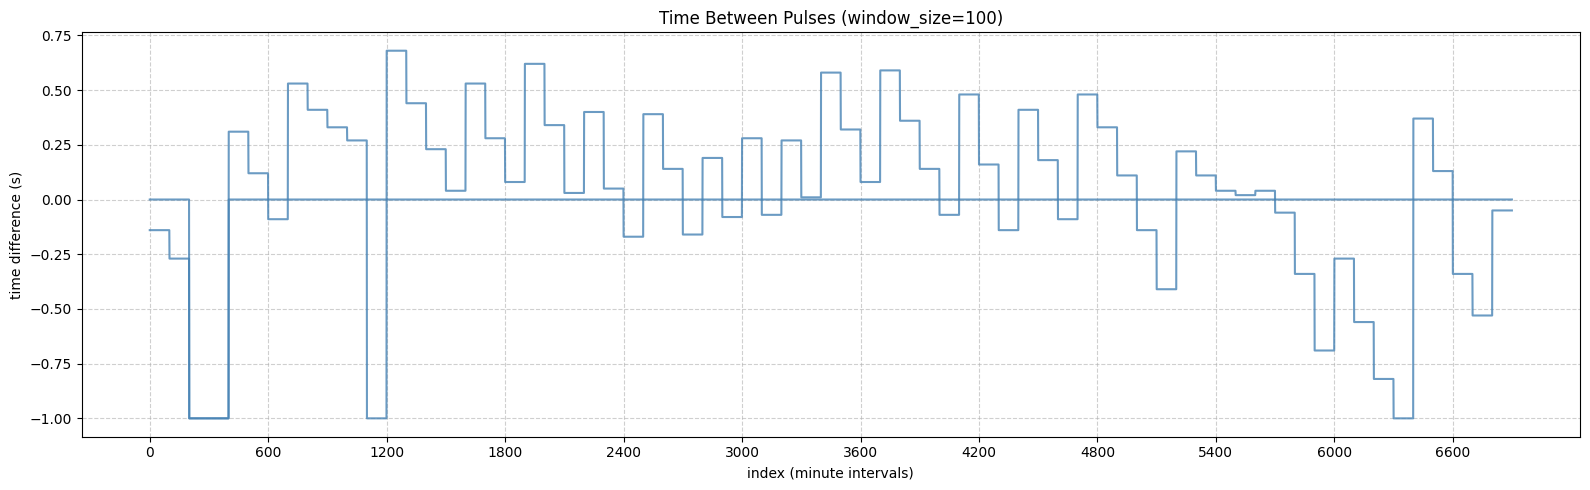

In [31]:

start_index = 0
end_index = 6900
value_index = 0

# Use the function to calculate the heart rate variability
calculate_hrv(aligned_df)

combined_plot(data=aligned_df, dts=dts, start_index=start_index, stop_index=end_index, value_index=0, ilist=[0,1] )

## k-means - clustering

In [68]:
import pandas as pd
from sklearn.cluster import KMeans

def train_kmeans_model(file_path, n_clusters=5):
    """
    Reads a CSV file and trains a KMeans clustering model with 6 clusters.

    Args:
    file_path (str): The path to the CSV file containing the data.

    Returns:
    KMeans: The trained KMeans model.
    """
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Check if data has the expected 4 features
    if data.shape[1] != 4:
        raise ValueError("The input CSV file must have exactly 4 columns representing features.")
    
    # Initialize and train the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data)
    
    return kmeans



def classify_and_save_clusters(model, file_path = None):
    """
    Classifies the instances in the CSV file using the provided KMeans model and saves the data with an additional
    column for the cluster number to a new file called 'clustered.csv'.

    Args:
    file_path (str): The path to the CSV file containing the data.
    model (KMeans): The trained KMeans model.
    """
    # Read the data from the file
    data = pd.read_csv(file_path)
    
    # Check if data has the expected 4 features
    if data.shape[1] != 4:
        raise ValueError("The input CSV file must have exactly 4 columns representing features.")
    
    # Predict the clusters for each instance in the data
    clusters = model.predict(data)
    
    # Add the cluster labels to the data
    data['Cluster'] = clusters
    
    # Save the new DataFrame with cluster labels to a new CSV file
    data.to_csv('clustered.csv', index=False)
    print("Data with cluster labels has been saved to 'clustered.csv'.")
    
    return data
    

# Example usage:
kmeans_model = train_kmeans_model('dts_features.csv')
kmeans_df = classify_and_save_clusters(kmeans_model, 'dts_features.csv')



Data with cluster labels has been saved to 'clustered.csv'.


In [69]:
kmeans_df

,Group1_Delta,Group2_Delta,hrv_1,hrv_2,Cluster
0,0.0,-0.27,32.4,48.6,0
1,0.0,-0.43,46.8,56.4,4
2,0.0,0.15,44.4,57.0,4
3,0.0,-0.02,47.1,58.8,4
4,0.0,-0.50,48.0,63.6,2
...,...,...,...,...,...
495,0.0,-0.45,44.4,48.6,0
496,0.0,-0.08,46.8,69.6,2
497,0.0,-0.50,46.5,71.4,2
498,0.0,-0.07,45.6,67.2,2


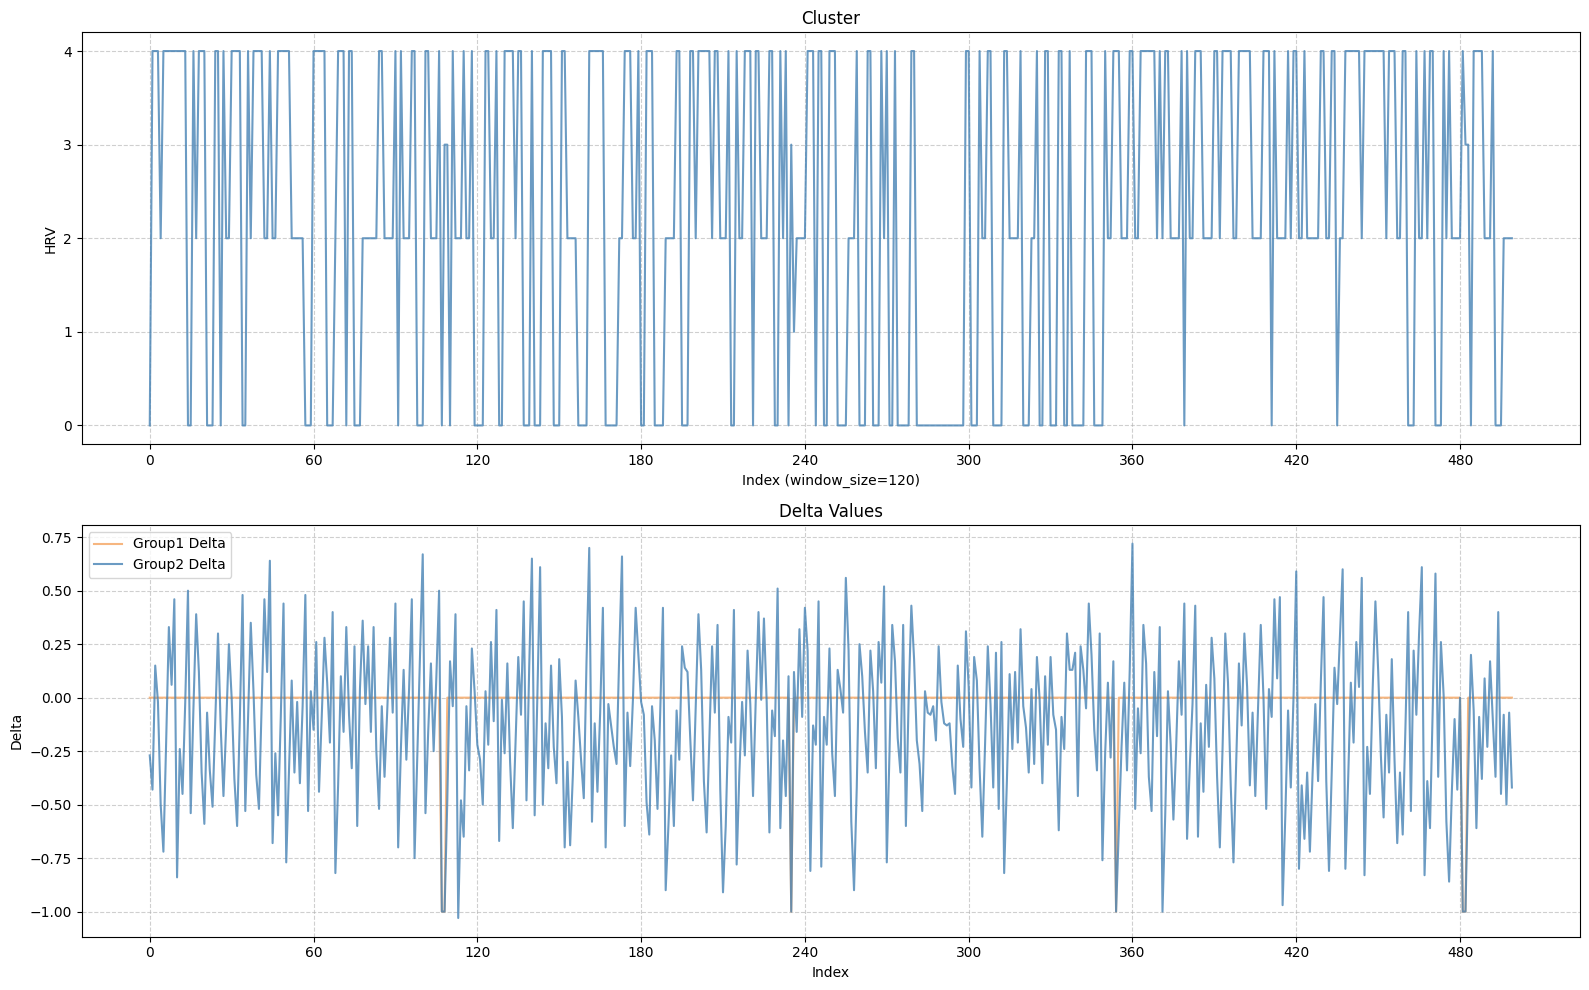

In [70]:
import matplotlib.pyplot as plt

def plot_hrv_and_deltas(data, start_index, end_index):
    """
    Plots HRV and Delta values from the specified range of data points.

    Args:
    data (DataFrame): The data to plot, expected to have columns 'Group1_Delta', 'Group2_Delta', 'hrv_1', 'hrv_2', and 'Cluster'.
    start_index (int): The starting index of the range of data points to plot.
    end_index (int): The ending index of the range of data points to plot.
    plot_clusters (bool): Whether to color-code the data points by clusters.
    """
    x_ticks = range(start_index, end_index + 1, 60)
    colors = ['sandybrown', 'steelblue', 'darkgreen', 'darkred', 'purple', 'cyan']

    fig, axs = plt.subplots(2, 1, figsize=(16, 10))  # Two subplots

    # Plot HRV data
    # if plot_clusters:
    axs[0].plot(data.index, data['Cluster'], color=colors[1], alpha=0.8)
    # else:
    axs[0].set_title('Cluster')
    axs[0].set_xlabel(f'Index (window_size={window_size})')
    axs[0].set_ylabel('HRV')
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks([0,1,2,3,4])
    axs[0].grid(axis='both', linestyle='--', alpha=0.6)

    # Plot Delta values
    axs[1].plot(data.index, data['Group1_Delta'], color=colors[0], alpha=0.8, label='Group1 Delta')
    axs[1].plot(data.index, data['Group2_Delta'], color=colors[1], alpha=0.8, label='Group2 Delta')

    axs[1].set_title('Delta Values')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Delta')
    axs[1].set_xticks(x_ticks)
    axs[1].grid(axis='both', linestyle='--', alpha=0.6)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `data` is your dataframe
kmeans_df = pd.read_csv('clustered.csv')
plot_hrv_and_deltas(kmeans_df, 0, len(kmeans_df) - 1)
